In [ ]:
!pip install -q easyocr pdf2image dataframe-image tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
!apt-get install -y tesseract-ocr
!pip install pytesseract
!pip install pandas
!pip install opencv-python-headless
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,289 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
!pip install -q timm
!pip install -q "accelerate>=0.20.3"

In [ ]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm
import pandas as pd
import torch
import pytesseract
from PIL import ImageDraw
from torchvision import transforms
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from pdf2image import convert_from_path
from transformers import TableTransformerForObjectDetection, AutoModelForObjectDetection, DetrImageProcessor, AutoImageProcessor, TableTransformerForObjectDetection
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

In [ ]:
# Upload the PDF file
uploaded = files.upload()

# Get the uploaded file name
pdf_path = next(iter(uploaded))
# pdf_path="LayoutLM.pdf"

Saving CoPali.pdf to CoPali.pdf


In [ ]:
# Convert PDF to a list of images
images = convert_from_path(pdf_path)

In [ ]:
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
processor = DetrImageProcessor.from_pretrained("microsoft/table-transformer-detection")
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

In [ ]:
# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
device = "cuda" if torch.cuda.is_available() else "cpu"
structure_model.to(device)

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [ ]:
model_name = "microsoft/table-transformer-detection"
# define image preprocessor for table transformer
image_processor = AutoImageProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # import table transformer model for table detection
# model = TableTransformerForObjectDetection.from_pretrained(model_name, revision="no_timm")

In [ ]:
class MaxResize(object):
  def __init__(self, max_size=800):
      self.max_size = max_size

  def __call__(self, image):
      width, height = image.size
      current_max_size = max(width, height)
      scale = self.max_size / current_max_size
      resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

      return resized_image

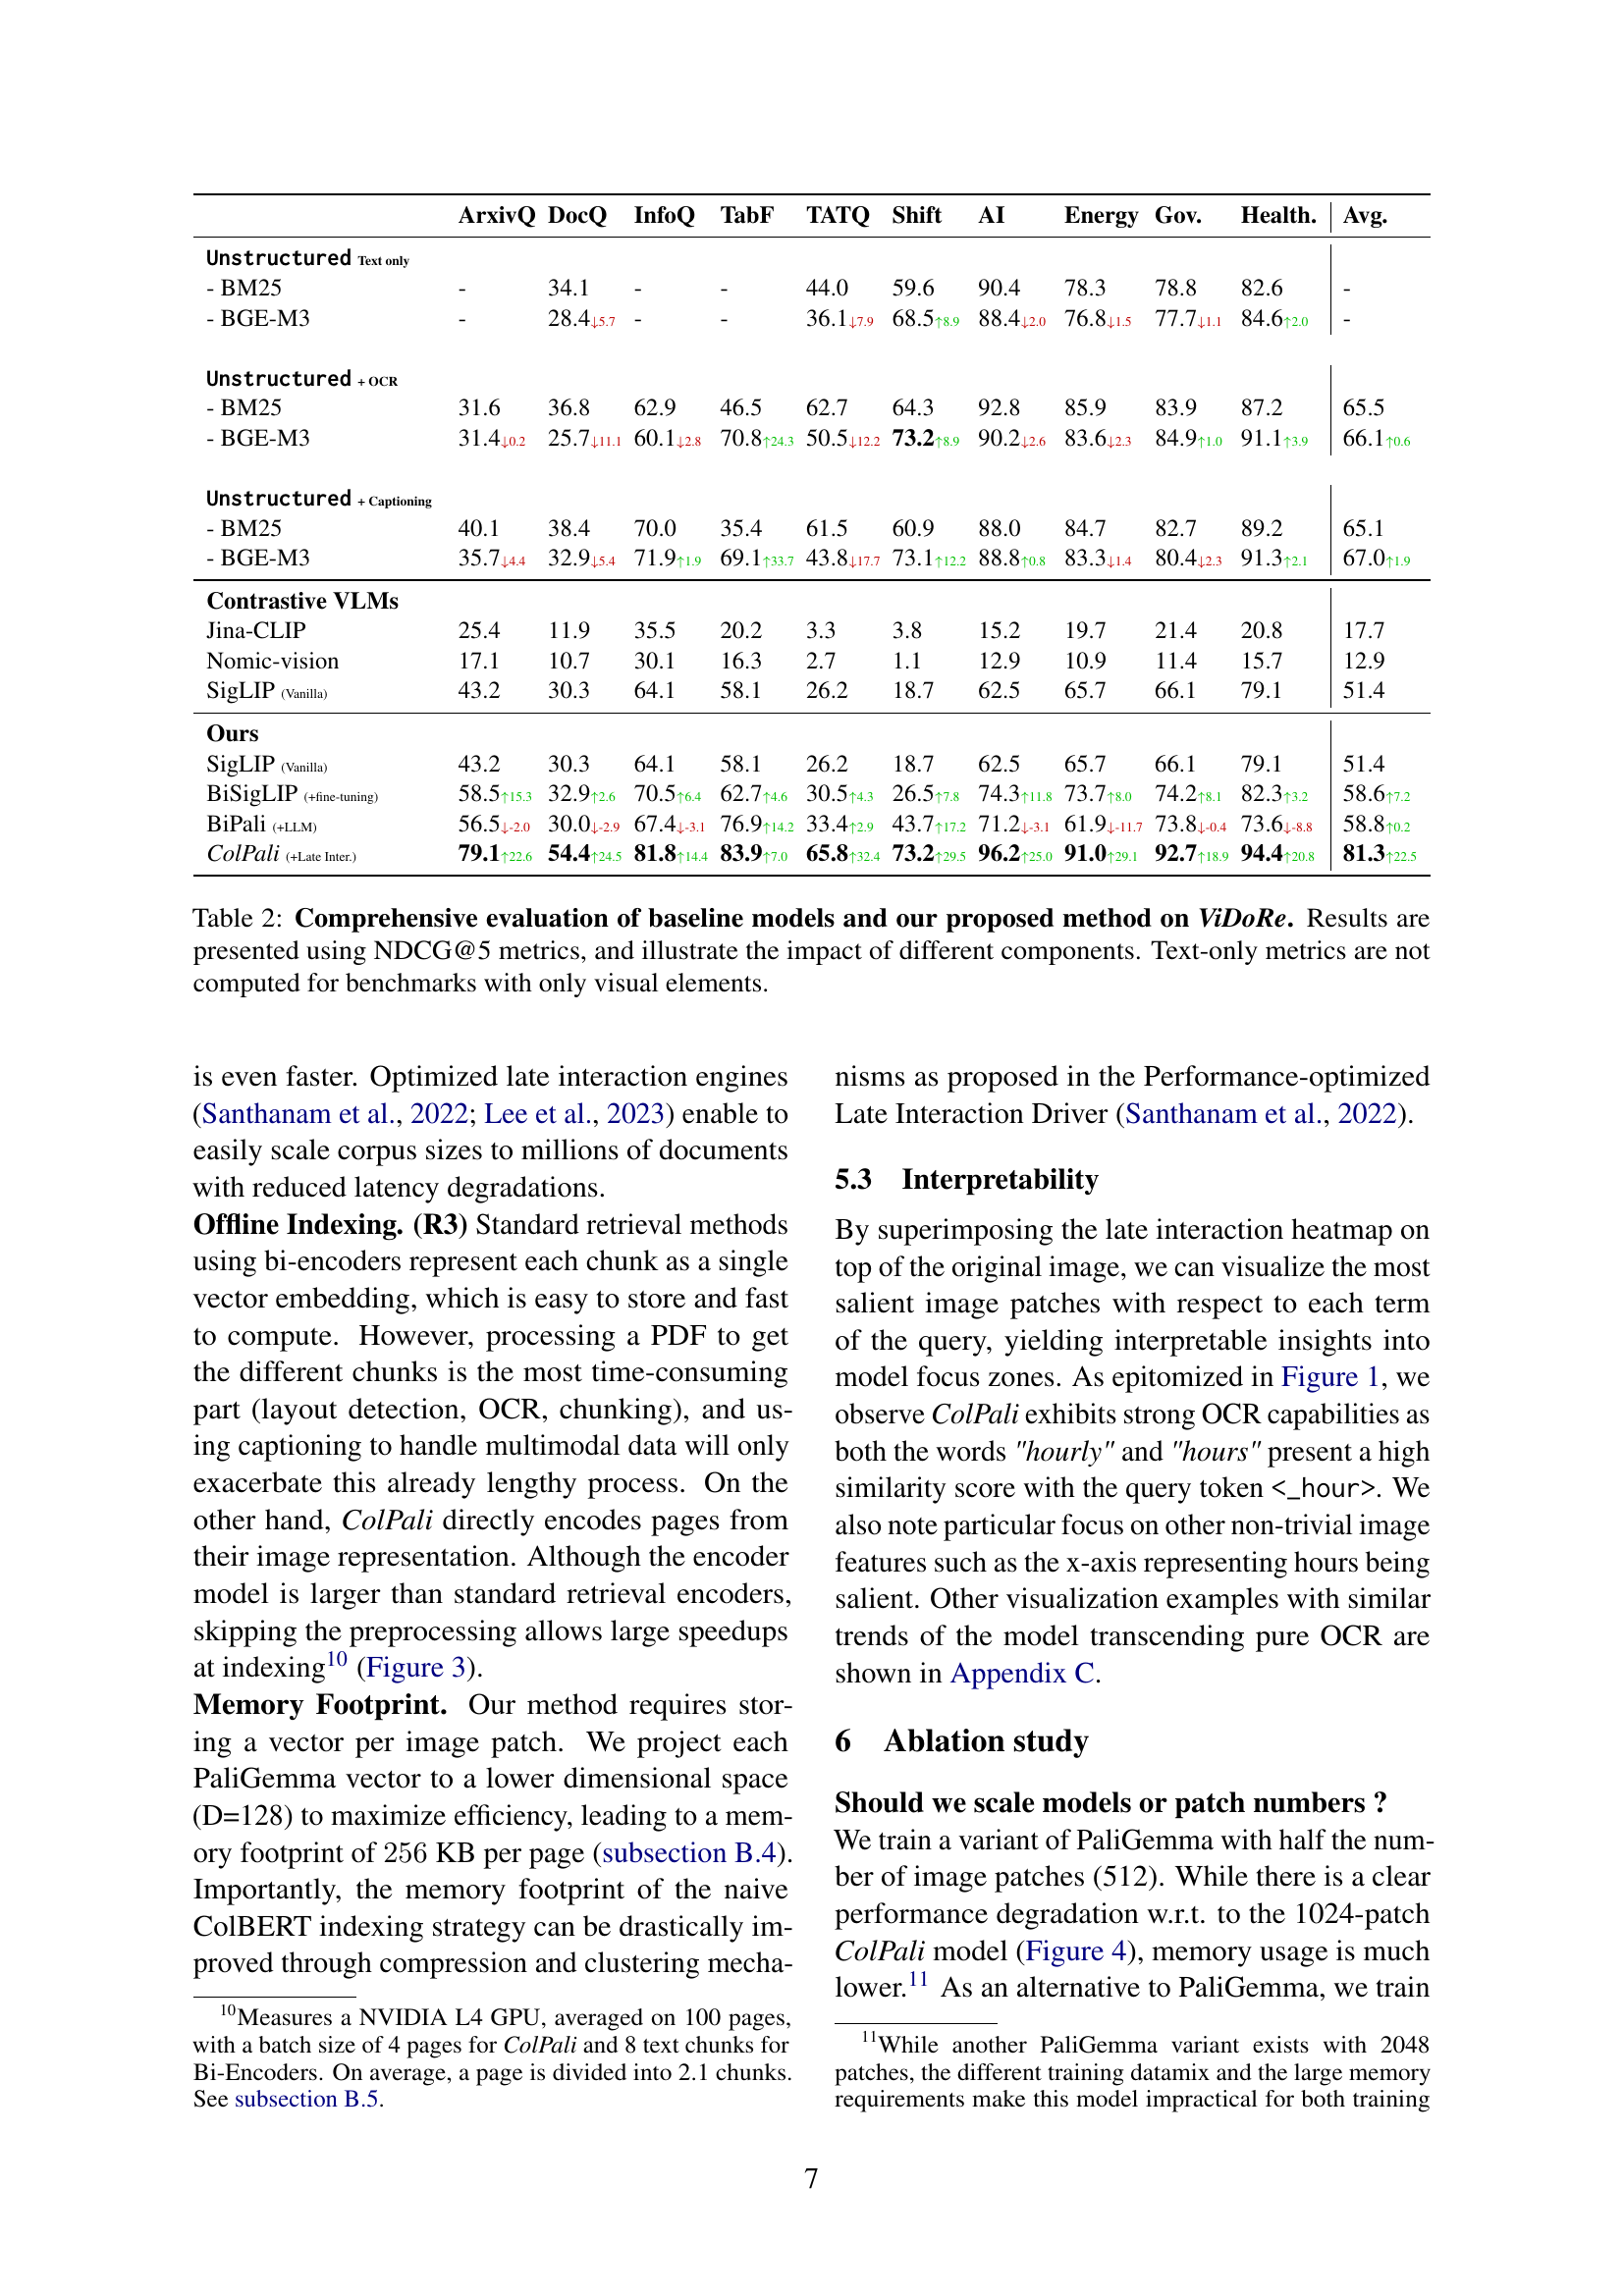

In [ ]:
# let's load an example image
image = images[6]
# image = images[18]
# image = images[21]
image

In [ ]:
def image_to_crops(img, objects, class_thresholds, padding):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    tokens = []
    width, height = img.size

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0] - padding["x"], bbox[1] - padding["y"], bbox[2] + padding["x"], bbox[3] + padding["y"]]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [ ]:
def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

In [ ]:
def plot_results(image, cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=1))
          text = f'{cell["label"]}: {score:0.2f}'
          # ax.text(xmin, ymin, text, fontsize=15,
          #         bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

In [ ]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

In [ ]:
def apply_ocr(image, cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

In [ ]:
def detectTableElements(image, padding):

  structure_transform = transforms.Compose([
    MaxResize(2000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  pixel_values = structure_transform(image).unsqueeze(0)
  pixel_values = pixel_values.to(device)

  # forward pass
  with torch.no_grad():
    outputs = structure_model(pixel_values)

  # update id2label to include "no object"
  structure_id2label = structure_model.config.id2label
  structure_id2label[len(structure_id2label)] = "no object"

  return outputs_to_objects(outputs, image.size, structure_id2label, padding)

In [ ]:
def highlight_tables(image, table_bbox, padding):
    # Create a drawing context for doc image
    doc_image = image.copy()
    draw = ImageDraw.Draw(doc_image)

    # Iterate over each table in the list
    for table in table_bbox:
        # Define the coordinates for the rectangle with padding for each table
        rectangle_coords = (table["bbox"][0] - padding,
                            table["bbox"][1] - padding,
                            table["bbox"][2] + padding,
                            table["bbox"][3] + padding)

        # Draw a red rectangle around the detected table
        draw.rectangle(rectangle_coords, outline="red", width=2)

    return doc_image

In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def outputs_to_objects(outputs, img_size, id2label, padding):

    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    coordinates = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            bboxWidthPadding = (bbox[2] - bbox[0]) * padding["x"] if padding["x"] > 0 else 0
            bboxHeightPadding = (bbox[3] - bbox[1]) * padding["y"] if padding["y"] > 0 else 0
            coordinates.append({'label': class_label, 'score': float(score),
                            'bbox': [float(bbox[0] - bboxWidthPadding), float(bbox[1] - bboxHeightPadding),
                                     float(bbox[2] + bboxWidthPadding), float(bbox[3] + bboxHeightPadding)]})

    coordinates = sorted(coordinates, key=lambda x: (x["bbox"][0], -x["bbox"][1]))
    return coordinates

In [ ]:
def tableDetect(image):

  img_size = image.size

  detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  pixel_values = detection_transform(image).unsqueeze(0)
  pixel_values = pixel_values.to(device)

  with torch.no_grad():
    outputs = model(pixel_values)

  m = outputs.logits.softmax(-1).max(-1)
  pred_labels = list(m.indices.detach().cpu().numpy())[0]
  pred_scores = list(m.values.detach().cpu().numpy())[0]
  pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
  pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

  objects = []
  for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
      class_label = id2label[int(label)]
      if not class_label == 'no object':
          objects.append({'label': class_label, 'score': float(score),
                          'bbox': [float(elem) for elem in bbox]})

  return objects

tableDetect = tableDetect(image)

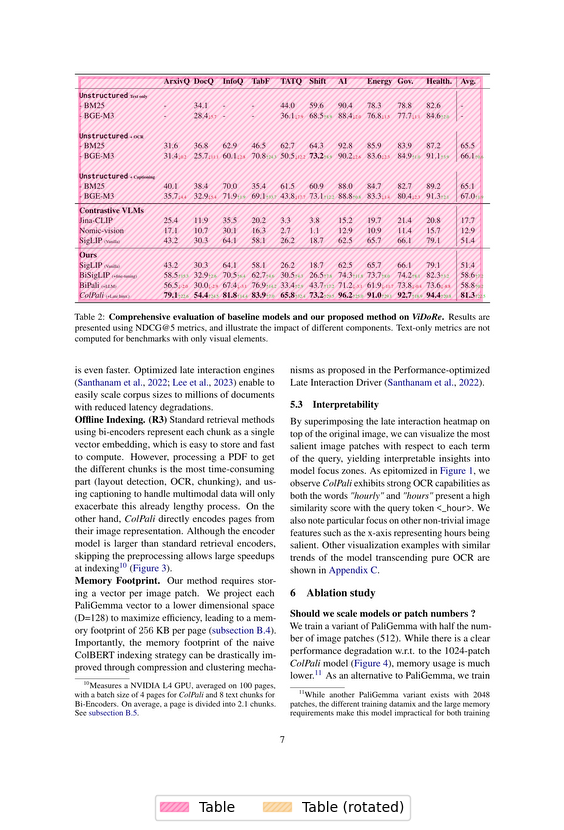

In [ ]:
fig = visualize_detected_tables(image, tableDetect)

In [ ]:
tableDetect

[{'label': 'table',
  'score': 0.9997830986976624,
  'bbox': [209.73233032226562,
   205.7256317138672,
   1429.7479248046875,
   881.4249267578125]}]

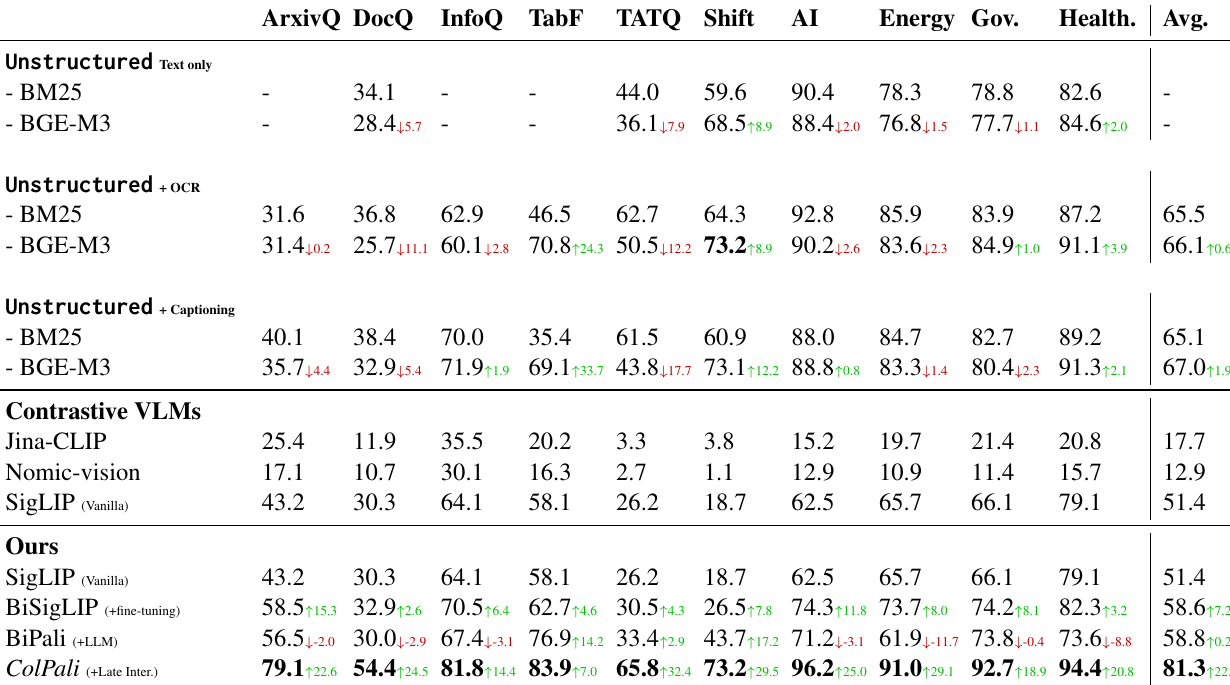

In [ ]:
detection_class_thresholds = {
    "table": 0.5,
}
crop_padding = {"x": 5, "y": 5}

tables_crops = image_to_crops(image, tableDetect, detection_class_thresholds, crop_padding)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [ ]:
crop_padding = {"x": 0, "y": 0}
tableElements = detectTableElements(cropped_table, crop_padding)

In [ ]:
def get_table_features(cropped_image, padding, sortby):

  # preprocess image input for table transformer
  inputs = image_processor(images = cropped_image, return_tensors="pt")

  # Move the input tensor to the same device as the model
  inputs = {k: v.to(device) for k, v in inputs.items()}

  # make prediction using table transformer
  outputs = structure_model(**inputs)

  # post process output to Pasval VOC bbox format
  target_sizes = torch.tensor([cropped_image.size[::-1]])
  results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

  # define a list to store detected features
  elements = []

  # iterate through all the detected features and store feature label, confidence score, and bbox values to cells list
  for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
      box = [round(i, 2) for i in box.tolist()]
      score = score.item()
      label = structure_model.config.id2label[label.item()]

      cell_dict = {"label":label,
                  "score":score,
                  "bbox":box
                  }

      elements.append(cell_dict)

  # Sort by first element and then by third element
  elements = sorted(elements, key=lambda x: x["bbox"][0] if sortby == "x" else x["bbox"][1])
  return elements

padding = {"x": 5, "y": 10}

features = [get_table_features(image["image"], padding, "x") for image in tables_crops]

In [ ]:
features

[[{'label': 'table row',
   'score': 0.9997907280921936,
   'bbox': [1.88, 104.35, 1226.47, 150.32]},
  {'label': 'table row',
   'score': 0.9994851350784302,
   'bbox': [2.01, 149.15, 1226.47, 194.01]},
  {'label': 'table row',
   'score': 0.9998573064804077,
   'bbox': [2.11, 73.5, 1226.28, 104.83]},
  {'label': 'table row',
   'score': 0.9995090961456299,
   'bbox': [2.15, 193.33, 1226.54, 225.79]},
  {'label': 'table projected row header',
   'score': 0.9997034668922424,
   'bbox': [2.16, 37.98, 1225.98, 73.83]},
  {'label': 'table',
   'score': 0.9999821186065674,
   'bbox': [2.19, 2.82, 1226.24, 678.76]},
  {'label': 'table row',
   'score': 0.9993917942047119,
   'bbox': [2.21, 270.46, 1226.54, 315.42]},
  {'label': 'table projected row header',
   'score': 0.9994539618492126,
   'bbox': [2.23, 522.69, 1226.62, 559.72]},
  {'label': 'table row',
   'score': 0.9996697902679443,
   'bbox': [2.23, 37.86, 1226.2, 73.96]},
  {'label': 'table row',
   'score': 0.9996161460876465,
   '

In [ ]:
tableHeaders = [entry for entry in tableElements if entry['label'] == 'table column header']

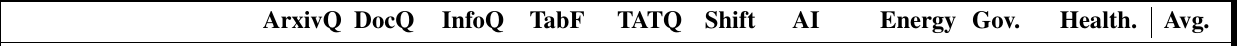

In [ ]:
detection_class_thresholds = {
    "table column header": 0.5,
}
crop_padding = {"x": 5, "y": 5}

header_crops = image_to_crops(cropped_table, tableHeaders, detection_class_thresholds, crop_padding)
cropped_header = header_crops[0]['image'].convert("RGB")
cropped_header

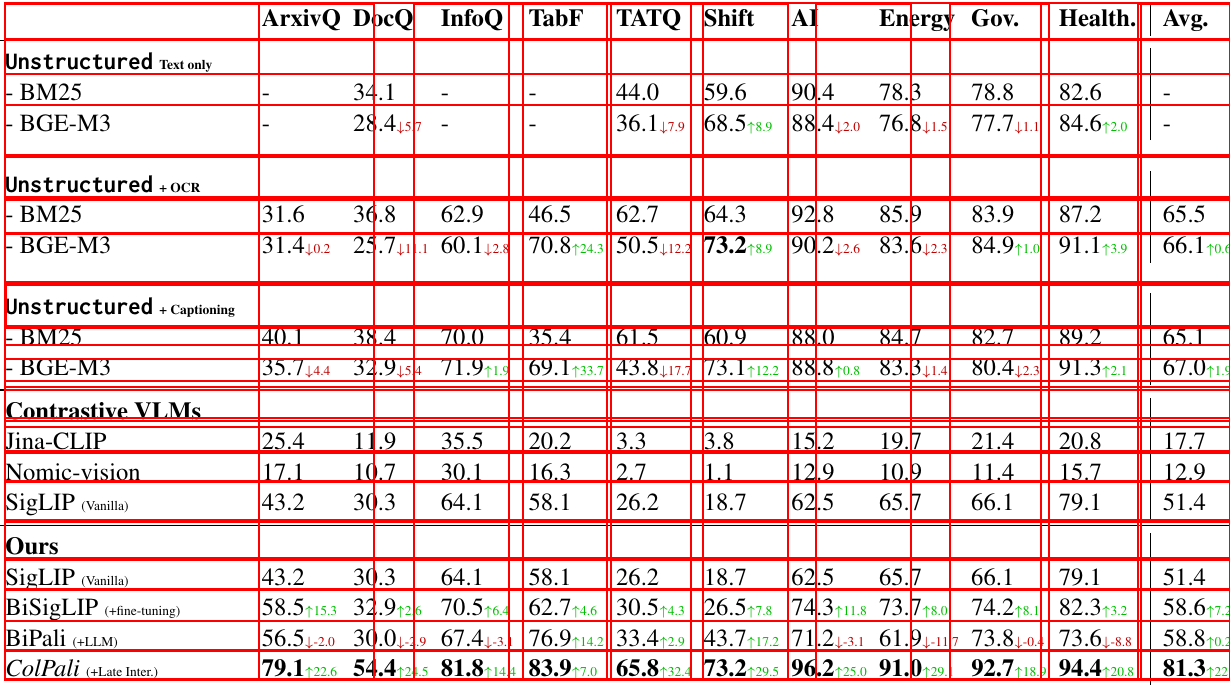

In [ ]:
highlight_tables(cropped_table, tableElements, 0)

In [ ]:
# Extract x0, y0, x1, y1 from the table and header
x0_table, y0_table, x1_table, y1_table = tableDetect[0]["bbox"]
x0_header, y0_header, x1_header, y1_header = tableHeaders[0]["bbox"]

# Adjust y0 of the table to be the y1 (bottom) of the header
new_y0_table = y1_header

In [ ]:
# The new table body coordinates will be:
tableBody = [{ 'label': 'table body', \
              'score': tableDetect[0]["score"], \
              'bbox': [x0_table + x0_header, y0_table + y1_header, x1_table, y1_table]}]

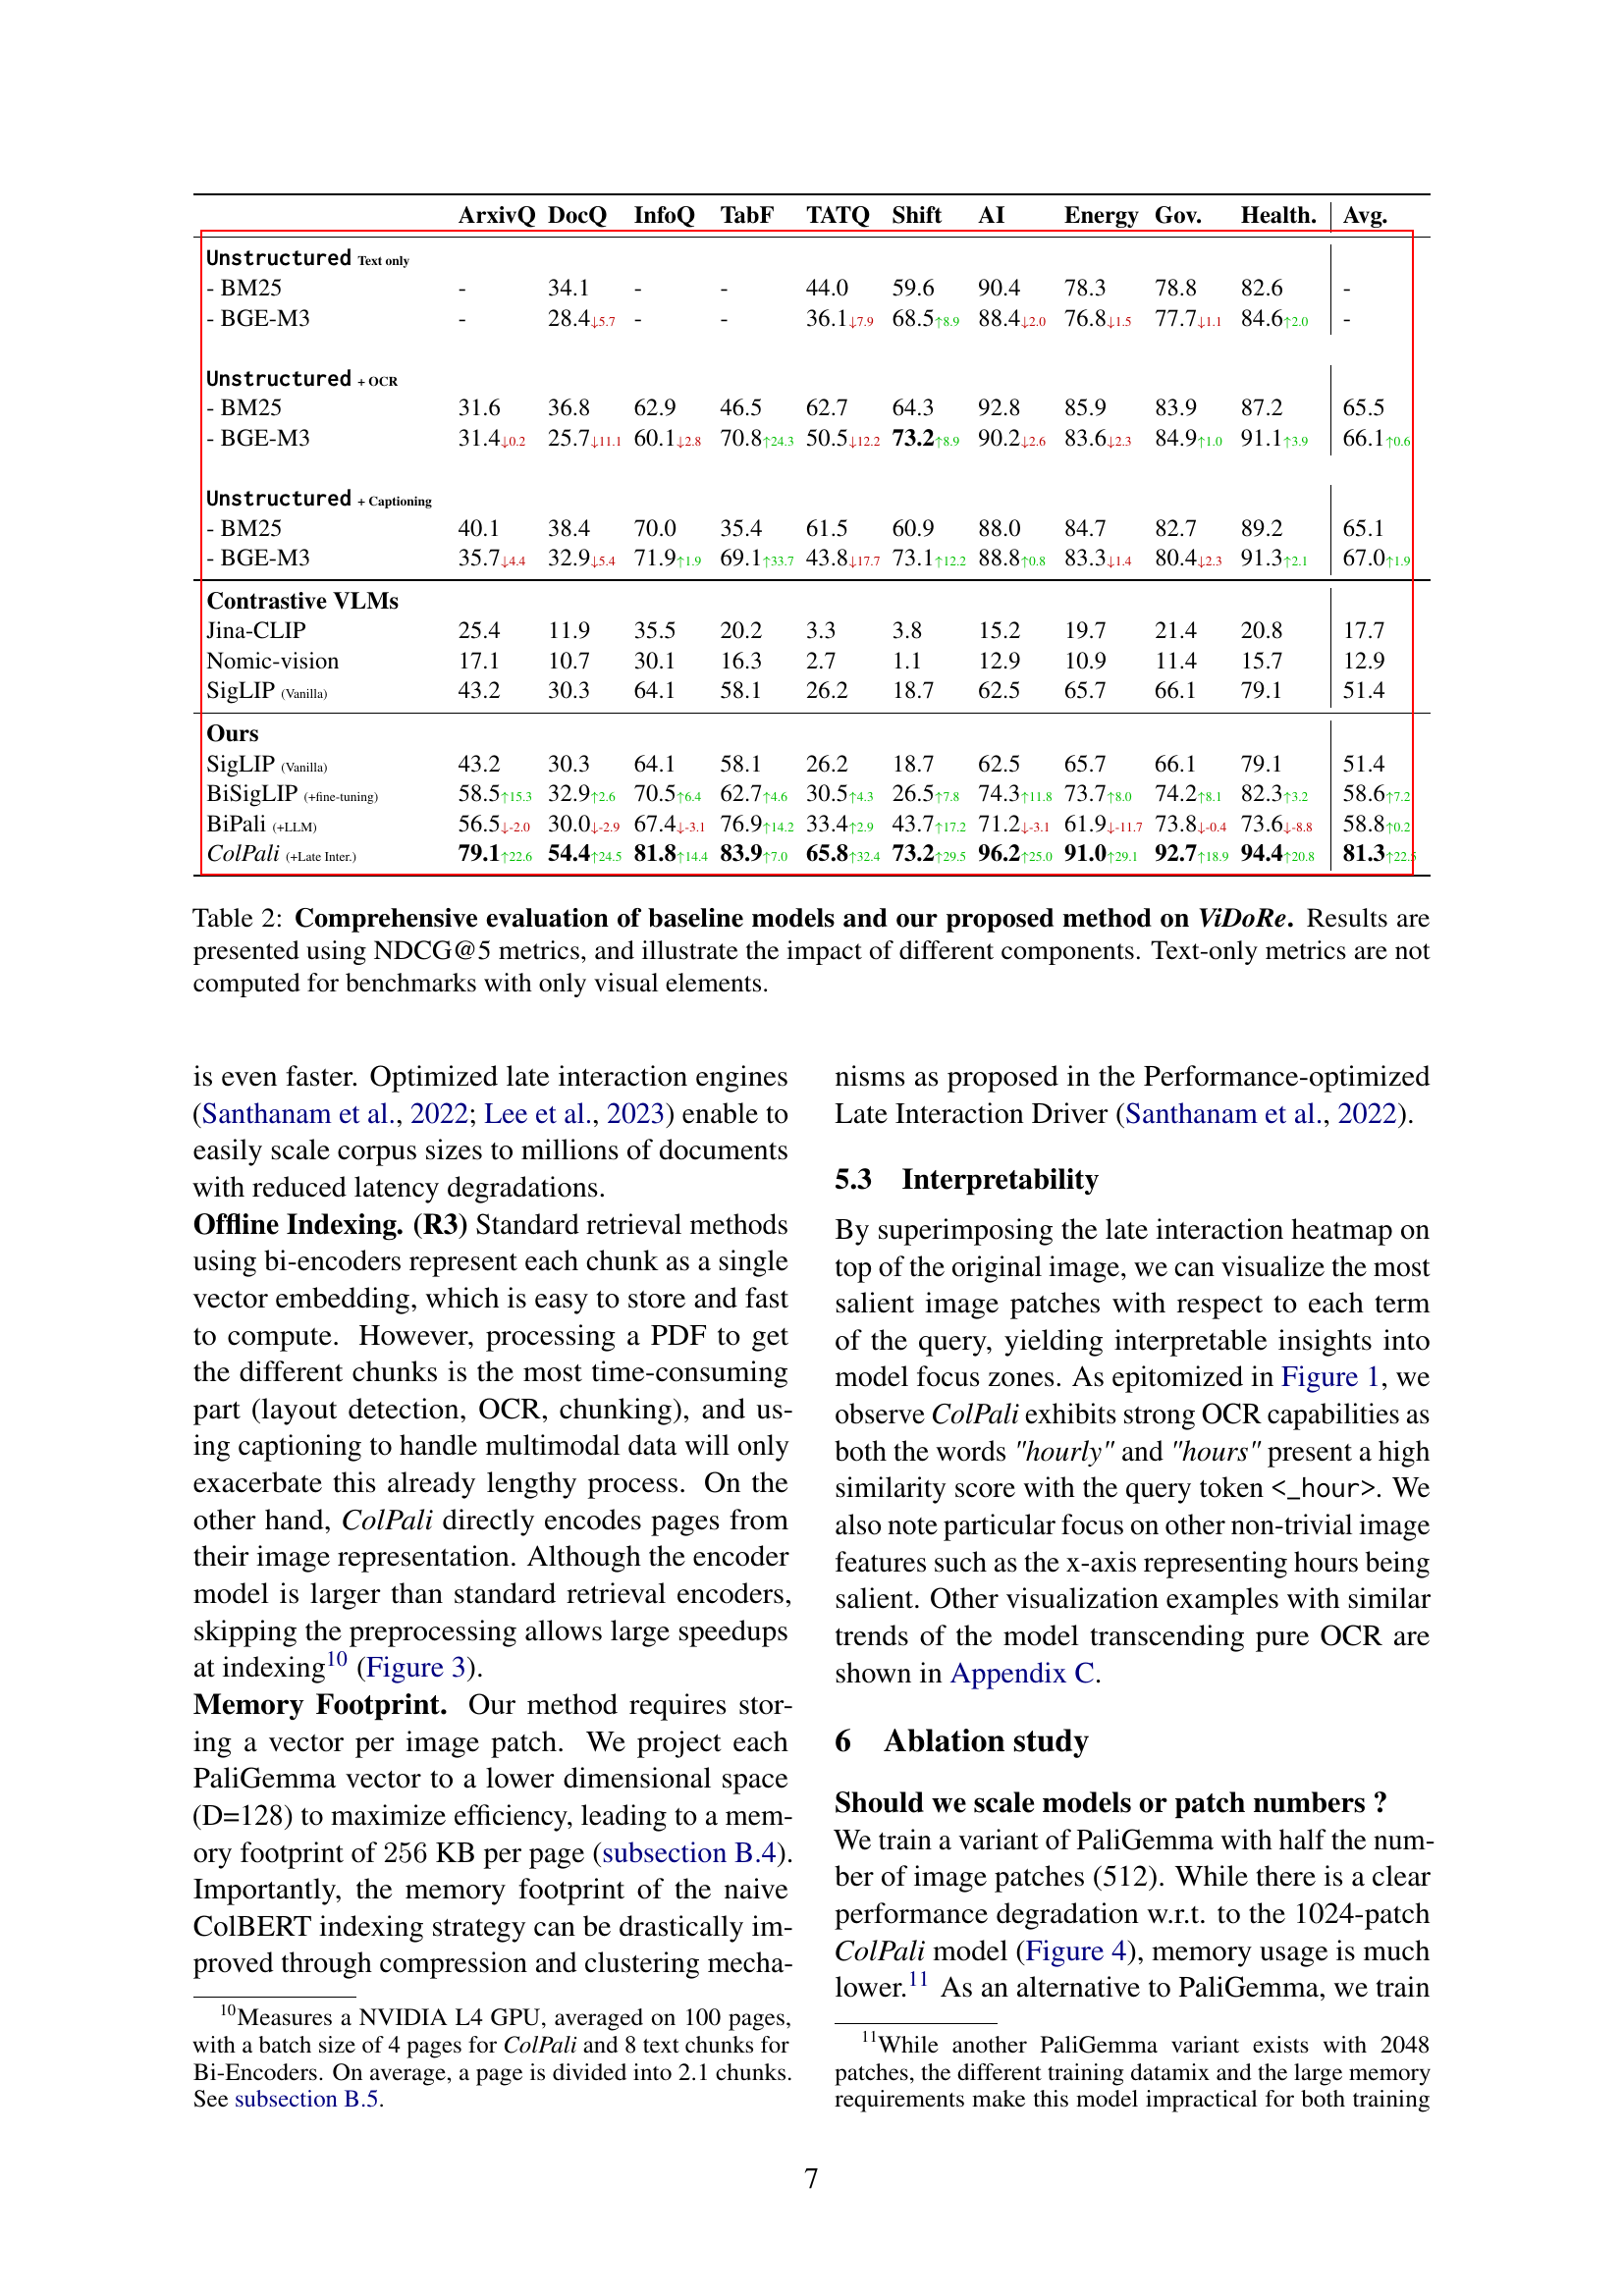

In [ ]:
highlight_tables(image, tableBody, 10)

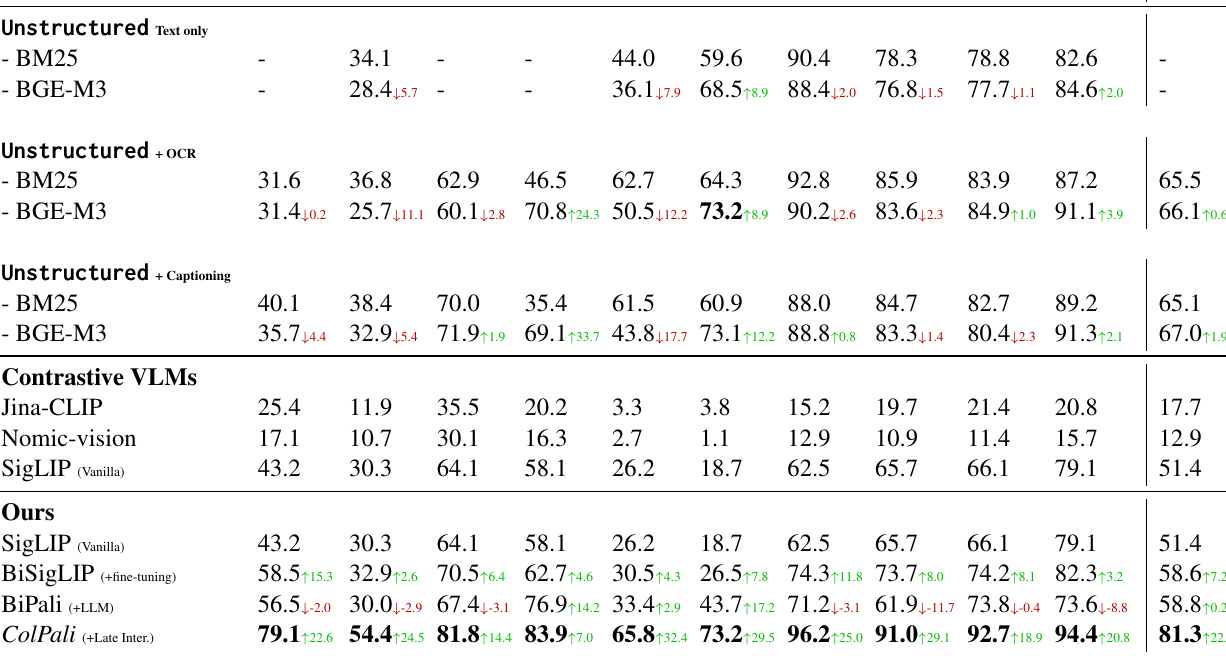

In [ ]:
tokens = []
detection_class_thresholds = {
    "table body": 0.5,
}
crop_padding = {"x": 5, "y": 10}

tableCropBodys = image_to_crops(image, tableBody, detection_class_thresholds, crop_padding)
tableCropBody = tableCropBodys[0]['image'].convert("RGB")
tableCropBody

In [ ]:
padding = {"x": 5, "y": 5}
bodyElements = get_table_features(tableCropBody, padding, "y")

[{'label': 'table row',
  'score': 0.9998458623886108,
  'bbox': [0.38, 11.15, 1413.85, 45.78]},
 {'label': 'table row',
  'score': 0.9996151924133301,
  'bbox': [0.21, 45.23, 1413.95, 87.05]},
 {'label': 'table row',
  'score': 0.9998002648353577,
  'bbox': [0.52, 87.1, 1413.77, 128.63]},
 {'label': 'table row',
  'score': 0.9996652603149414,
  'bbox': [0.14, 129.29, 1414.23, 171.18]},
 {'label': 'table row',
  'score': 0.9998242259025574,
  'bbox': [0.1, 171.51, 1414.18, 213.78]},
 {'label': 'table row',
  'score': 0.9999022483825684,
  'bbox': [0.25, 213.72, 1413.99, 250.7]}]

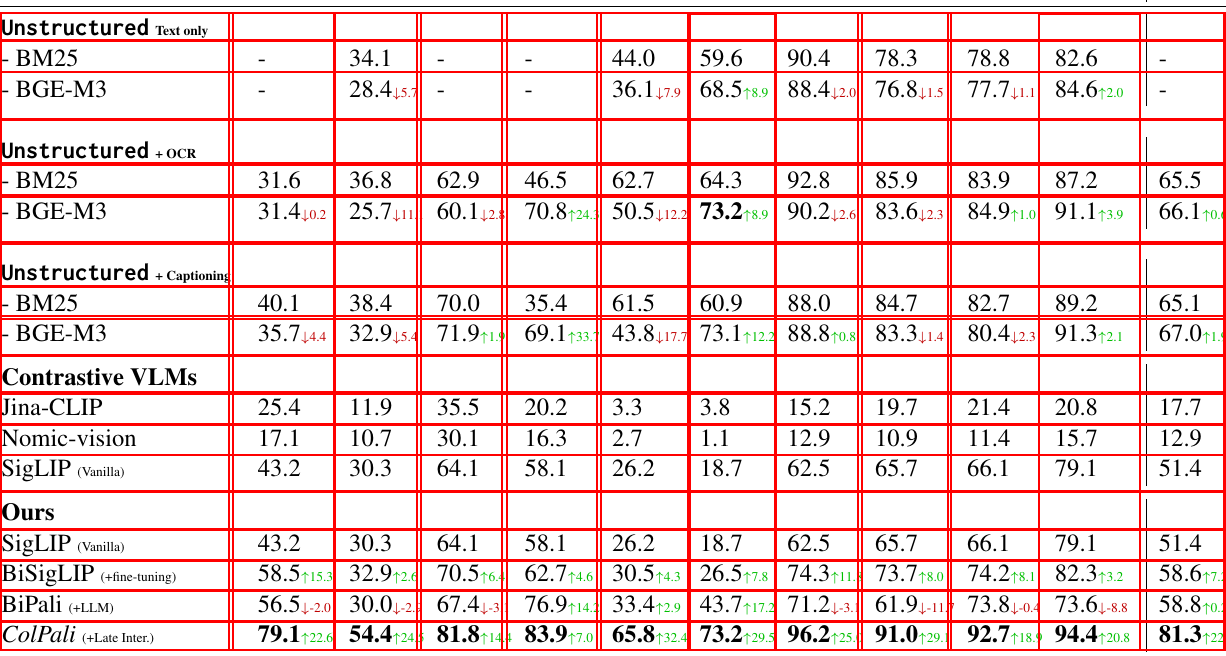

In [ ]:
highlight_tables(tableCropBody, bodyElements, 0)

In [ ]:
bodyRowElements = [entry for entry in bodyElements if entry['label'] == 'table row']
bodyColumnElements = [entry for entry in bodyElements if entry['label'] == 'table column']

In [ ]:
def calculate_iou(box1, box2):
  # Calculate the coordinates of the intersection
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  # Check if there is an intersection
  if x1 >= x2 or y1 >= y2:
      return 0

  # Calculate the area of intersection
  inter_area = (x2 - x1 + 1) * (y2 - y1 + 1)

  # Calculate the area of each bounding box
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

  # Calculate   the IoU
  iou = inter_area / float(box1_area + box2_area - inter_area)
  return iou

In [ ]:
def filter_overlapping_boxes(boxes, margin=0.5):
  filtered_boxes = []
  for box1 in boxes:
    is_overlapping = False
    for box2 in filtered_boxes:
      print(calculate_iou(box1['bbox'], box2['bbox']))
      print(calculate_iou(box1['bbox'], box2['bbox']) > (1 - margin))
      if calculate_iou(box1['bbox'], box2['bbox']) > (1 - margin):
        is_overlapping = True
        break
    if not is_overlapping:
      filtered_boxes.append(box1)
  return filtered_boxes

In [ ]:
# Filter overlapping boxes with a margin of 0.5
filtered_data = filter_overlapping_boxes(bodyRowElements, margin=0.0)
print(filtered_data)

0.01956518598576069
False
0
False
0.021587358747946768
False
0
False
0
False
0
False
0
False
0
False
0
False
0.01605463892389372
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0.027435884218034615
False
0
False
0
False
0
False
0
False
0
False
0
False
0.02602337532465654
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0.01890832821418934
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0.0240413259987178
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0.020978932687450994
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
Fals

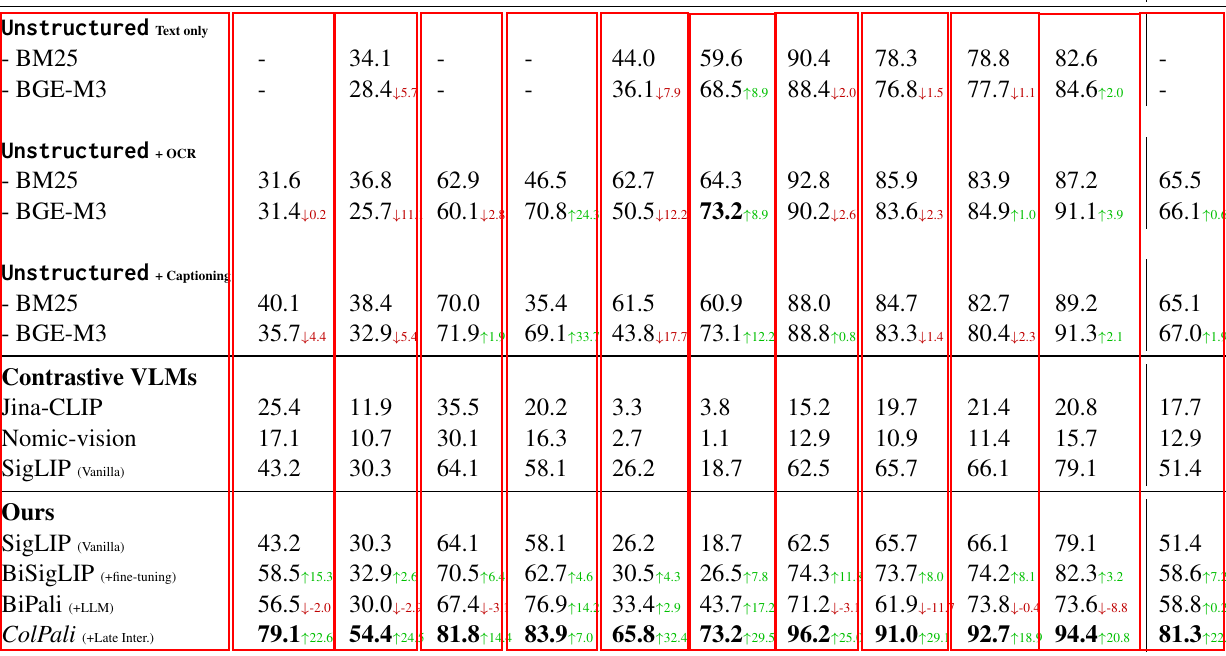

In [ ]:
highlight_tables(tableCropBody, bodyColumnElements, 0)